In [1]:
#@title Imports
import pandas as pd
import numpy as np
import pickle
import time
import os
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, plot_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#@title Setup
kaggle = False
colab = True

if kaggle:
    print("Running in Kaggle environment...")
    comp_path = "/kaggle/input/optiver-trading-at-the-close/"
    train_path = f"{comp_path}/train.csv"
    models_path = f"{comp_path}/models/"

if colab:
    import os
    from google.colab import drive

    mount_path = f"/content/drive/"

    if not os.path.ismount(mount_path):
        print("Mounting Google Drive...")
        drive.mount(mount_path, force_remount=True)
    comp_path = f"{mount_path}MyDrive/optiver"

models_path = f"{comp_path}/models/"
train_path = f"{comp_path}/train.csv"
train_eng_path = f"{comp_path}/train_eng.pkl"

Mounting Google Drive...
Mounted at /content/drive/


In [3]:
#@title Configuration

PRICE_COLS = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
SIZE_COLS = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

TRAIN_SPLITS = 5
SPLIT_DATE = 390

WINDOWS = [1, 2, 3, 10]

LGB_PARAMS = {
  'learning_rate'     : 0.005,
  'max_depth'         : 14,
  'n_estimators'      : 5000,
  'num_leaves'        : 1023,
  'objective'         : 'mae',
  'subsample'         : .2,
  'colsample_bytree'  : .3,
  'num_threads'       : 32,
  'device'            : 'cpu',
}

In [4]:
#@title Read train data

def read_train() -> pd.DataFrame:
  print("Reading train data...")
  train_df = pd.read_csv(train_path)
  print(f"Rows:\n{train_df.isnull().sum()}")
  print(f"Total NaN values: {train_df.isnull().sum().sum()}")

  train_df = train_df.dropna(subset=["ask_price"])
  train_df.loc[train_df['seconds_in_bucket'] <= 300, "near_price"] = 0
  train_df.loc[train_df['seconds_in_bucket'] <= 300, "far_price"] = 0
  train_df['far_price'] = train_df['far_price'].interpolate()

  print(f"Total NaN values after preprocessing: {train_df.isnull().sum().sum()}")
  return train_df

In [5]:
#@title Util functions
def save_pickle(data, file_path):
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
  with open(file_path, 'wb') as file:
      pickle.dump(data, file)
  print(f"Data saved to {file_path}")

def load_pickle(file_path):
  if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
      data = pickle.load(file)
    return data
  else:
    raise FileNotFoundError(f"No such file: {file_path}")

def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Feature Engineering

In [6]:
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/442851
stock_weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
stock_weights = {int(k):v for k,v in enumerate(stock_weights)}

In [7]:
def global_features(df) -> pd.DataFrame:
  global_stock_id_feats = {
      "median_size": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
      "std_size": df.groupby("stock_id")["bid_size"].std() + df.groupby("stock_id")["ask_size"].std(),
      "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["bid_size"].min(),
      "median_price": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
      "std_price": df.groupby("stock_id")["bid_price"].std() + df.groupby("stock_id")["ask_price"].std(),
      "ptp_price": df.groupby("stock_id")["bid_price"].max() - df.groupby("stock_id")["ask_price"].min(),
  }

  for key, value in global_stock_id_feats.items():
      df[f"global_{key}"] = df["stock_id"].map(value.to_dict())
  return df

def time_based_features(df) -> pd.DataFrame:
  df["day_of_week"] = df["date_id"] % 5
  df["seconds"] = df["seconds_in_bucket"] % 60
  df["minute"] = df["seconds_in_bucket"] // 60
  return df

def statistical_agg_features(df) -> pd.DataFrame:
  for func in ["mean", "std", "skew", "kurt","max"]:
    df[f"all_prices_{func}"] = df[PRICE_COLS].agg(func, axis=1)
    df[f"all_sizes_{func}"] = df[SIZE_COLS].agg(func, axis=1)
  return df

def feature_engineering(df) -> pd.DataFrame:
  print("Engineering features...")
  df["volume"] = df["ask_size"] + df["bid_size"]
  df["mid_price"] = (df["ask_price"] + df["bid_price"]) / 2

  df['bid_ask_spread'] = df['ask_price'] - df['bid_price']
  df['bid_ask_ratio'] = df['bid_price'] / df['ask_price']
  df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
  df["market_urgency"] = df["bid_ask_spread"] * df["liquidity_imbalance"]
  df["market_urgency_v2"] = (df["ask_price"]+df["bid_price"])/2 - (df["bid_price"]*df["bid_size"]+df["ask_price"]*df["ask_size"]) / (df["bid_size"]+df["ask_size"])

  df["stock_weights"] = df["stock_id"].map(stock_weights)
  df["weighted_wap"] = df["stock_weights"] * df["wap"]

  ss = df.groupby('time_id')['weighted_wap'].sum()/df.groupby('time_id')['stock_weights'].sum()
  ss = ss.reset_index()
  ss.columns = ['time_id','indexwap']

  df = pd.merge(df,ss,how='left',on='time_id')
  df['indexwapdiff'] = df['wap'] - df['indexwap']

  df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
  df["spread_intensity"] = df.groupby(['stock_id'])['bid_ask_spread'].diff()
  df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
  df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
  df['depth_pressure2'] = (df['ask_size'] + df['bid_size']) * (df['far_price'] + df['near_price'])

  df = global_features(df)
  df = reduce_mem_usage(df, verbose=True)
  df = time_based_features(df)
  df = statistical_agg_features(df)
  print(df.columns)
  feature_name = [i for i in df.columns if i not in ["row_id", "time_id"]]
  return df[feature_name]

In [8]:
if os.path.exists(train_eng_path):
  print(f'Found existing data saved in {train_eng_path}, loading...')
  df = load_pickle(train_eng_path)
else:
  df = read_train()
  df = feature_engineering(df)
  save_pickle(df, train_eng_path)

print(df.columns)

Found existing data saved in /content/drive/MyDrive/optiver/train_eng.pkl, loading...
Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'volume', 'mid_price', 'bid_ask_spread',
       'bid_ask_ratio', 'liquidity_imbalance', 'market_urgency',
       'market_urgency_v2', 'stock_weights', 'weighted_wap', 'indexwap',
       'indexwapdiff', 'imbalance_momentum', 'spread_intensity',
       'price_pressure', 'depth_pressure', 'depth_pressure2',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price',
       'day_of_week', 'seconds', 'minute', 'all_prices_mean', 'all_sizes_mean',
       'all_prices_std', 'all_sizes_std', 'all_prices_skew', 'all_sizes_skew',
       'all_prices_kurt', 'all_sizes_kurt', 'all_prices_max', 'all

# Model

In [9]:
#@title Model definition

model = LGBMRegressor(**LGB_PARAMS)

In [10]:
#@title Train Model & Cross Validation
cv_df = df[df['date_id'] <= SPLIT_DATE].reset_index(drop=True)
features = [c for c in cv_df.columns if c not in ['target', 'date_id', 'time_id']]

tscv = TimeSeriesSplit(n_splits=TRAIN_SPLITS)

for fold, (train_idx, val_idx) in enumerate(tscv.split(cv_df)):
    X_train, y_train = cv_df.loc[train_idx, features], cv_df.loc[train_idx, 'target']
    X_val, y_val = cv_df.loc[val_idx, features], cv_df.loc[val_idx, 'target']

    train_days = cv_df.loc[train_idx, 'date_id'].unique()
    val_days = cv_df.loc[val_idx, 'date_id'].unique()

    print(f"Fold {fold}: Training on {len(train_days)} days | Validating on {len(val_days)} days")
    print(f"Validation Date Range: {val_days.min()} to {val_days.max()}")

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='mae',
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100)
        ]
    )
    save_pickle(model, f"{models_path}lgbm_fold_{fold}.pkl")

Fold 0: Training on 67 days | Validating on 67 days
Validation Date Range: 66 to 132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.364929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10350
[LightGBM] [Info] Number of data points in the train set: 707970, number of used features: 48
[LightGBM] [Info] Start training from score -0.050068
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 5.21918	valid_1's l1: 7.0937
[200]	training's l1: 5.13793	valid_1's l1: 7.05069
[300]	training's l1: 5.07294	valid_1's l1: 7.0269
[400]	training's l1: 5.01681	valid_1's l1: 7.01383
[500]	training's l1: 4.96512	valid_1's l1: 7.00616
[600]	training's l1: 4.91613	valid_1's l1: 7.00119
[700]	training's l1: 4.86923	valid_1's l1: 6.99853
[800]	training's l1: 4.82303	valid_1's l1: 6.99706
[900]	training's l1: 4.77934	valid_1's l1: 6.99633
[LightGBM] [Warning] No further splits with positiv

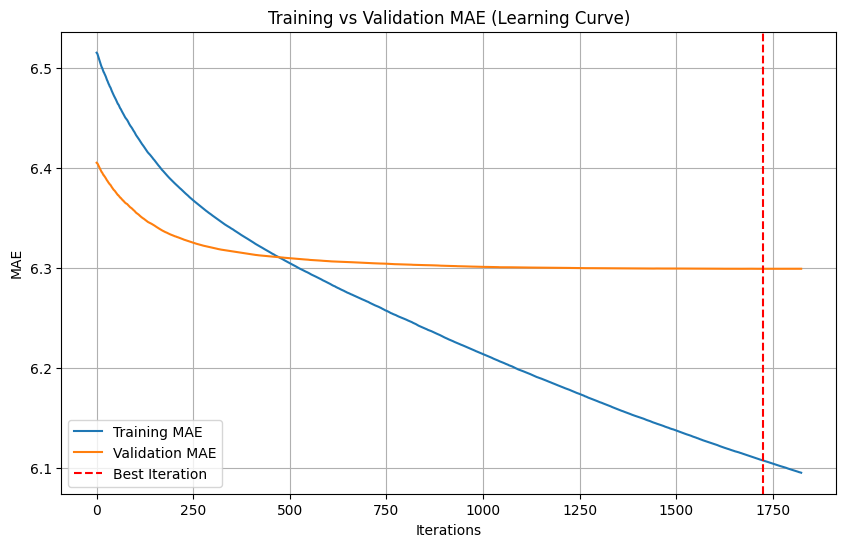

In [12]:
#@title Plot Training vs Validation MAE
evals_result = model.evals_result_

train_mae = evals_result['training']['l1']
val_mae = evals_result['valid_1']['l1']

plt.figure(figsize=(10, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.axvline(x=model.best_iteration_, color='r', linestyle='--', label='Best Iteration')
plt.title('Training vs Validation MAE (Learning Curve)')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

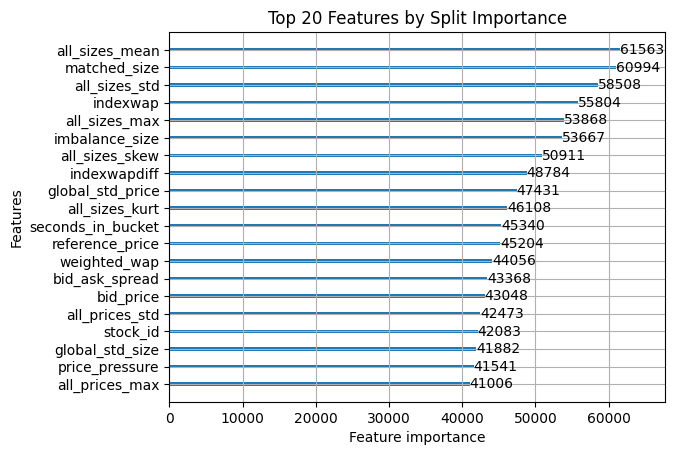

In [13]:
#@title Plot Feature Importance
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='split')
plt.title('Top 20 Features by Split Importance')
plt.show()

In [14]:
#@title Local Private LB
best_model = load_pickle(f"{models_path}lgbm_fold_4.pkl")

holdout_df = df[df['date_id'] > SPLIT_DATE].reset_index(drop=True)
X_test = holdout_df[features]
y_test = holdout_df['target']

preds = best_model.predict(X_test)
mae_score = np.mean(np.abs(y_test - preds))

print(f"Local Private LB MAE Score: {mae_score:.4f}")

Local Private LB MAE Score: 5.9238
